Non-plastic spiking network with conductance-based synapses and balanced state demo (with asynchronous irregular spiking).

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.ndimage import uniform_filter1d as mv_avg
from scipy.sparse import csc_matrix
from scipy import stats

from aux import Generic
from disp import set_font_size, set_color

cc = np.concatenate

Membrane dynamics for cell $i$:

$$C\cfrac{dv^i}{dt} = -g_L^i(v^i - E_L) - g_E^i(t)(v^i - E_E) - g_I^i(t)(v^i - E_I) + I_{EXT}^i(t)$$

Typical membrane time constant: $$\tau_m = C/g_L \sim 20 \textrm{ms} = 0.2 \textrm{nF} / 10 \textrm{nS} = .2 \textrm{nF}\times100\textrm{M}\Omega$$

Synaptic dynamics:

$$\cfrac{dg^i_E}{dt} = \cfrac{-g^i_E}{\tau_E} + \sum_{j} w^{ij}_E \sum_{t^j} \delta(t - t^j)$$

with $t^j$ indexing the spike times in neuron $j$. I.e. if left alone excitatory conductance of cell $i$ decays to zero with a time constant $\tau_E$, and in response to upstream spike from neuron $j$, immediately jumps by $w_E^{ij}$, so $w_E^{ij}$ specifies instantaneous conductance changes in neuron $i$ in response to spike from neuron $j$. Similar for inhibitory conductances $g_I^i$.

Network class:

In [2]:
class LIFNtwk(object):
    """Network of leaky integrate-and-fire neurons with conductance-based synapses."""
    
    def __init__(self, c_m, g_l, e_l, v_th, v_r, t_r, e_s, t_s, w_r, w_u, sparse=True):
        # ntwk size
        n = next(iter(w_r.values())).shape[0]
        
        # process inputs
        if type(t_r) in [float, int]:
            t_r = t_r * np.ones(n)
            
        if type(v_r) in [float, int]:
            v_r = v_r * np.ones(n)
            
        self.n = n
        self.c_m = c_m
        self.g_l = g_l
        self.t_m = c_m / g_l
        self.e_l = e_l
        self.v_th = v_th
        self.v_r = v_r
        self.t_r = t_r
        
        self.e_s = e_s
        self.t_s = t_s
        
        if sparse:  # sparsify connectivity if desired
            self.w_r = csc_matrix(w_r)
            self.w_u = csc_matrix(w_u) if w_u is not None else w_u
        else:
            self.w_r = w_r
            self.w_u = w_u

        self.syns = list(self.e_s.keys())
        
    def run(self, dt, clamp, i_ext, spks_u=None):
        """
        Run simulation.
        
        :param dt: integration timestep (s)
        :param clamp: dict of times to clamp certain variables (e.g. to initialize)
        :param i_ext: external current inputs (either 1D or 2D array, length = num timesteps for smln)
        :param spks_up: upstream inputs
        """
        n = self.n
        n_t = len(i_ext)
        syns = self.syns
        c_m = self.c_m
        g_l = self.g_l
        e_l = self.e_l
        v_th = self.v_th
        v_r = self.v_r
        t_r = self.t_r
        t_r_int = np.round(t_r/dt).astype(int)
        e_s = self.e_s
        t_s = self.t_s
        w_r = self.w_r
        w_u = self.w_u
        
        if spks_u is not None:
            assert len(i_ext) == len(spks_u)
        
        # make data storage arrays
        gs = {syn: np.nan * np.zeros((n_t, n)) for syn in syns}
        vs = np.nan * np.zeros((n_t, n))
        spks = np.zeros((n_t, n), dtype=bool)
        
        rp_ctr = np.zeros(n, dtype=int)
        
        # convert float times in clamp dict to time idxs
        ## convert to list of tuples sorted by time
        tmp_v = sorted(list(clamp.v.items()), key=lambda x: x[0])
        tmp_spk = sorted(list(clamp.spk.items()), key=lambda x: x[0])
        clamp = Generic(
            v={int(round(t_/dt)): f_v for t_, f_v in tmp_v},
            spk={int(round(t_/dt)): f_spk for t_, f_spk in tmp_spk})
        
        # loop over timesteps
        for t_ctr in range(len(i_ext)):
            
            # update conductances
            for syn in syns:
                if t_ctr == 0:
                    gs[syn][t_ctr, :] = 0
                else:
                    g = gs[syn][t_ctr-1, :]
                    # get weighted spike inputs
                    ## recurrent
                    spks_w = w_r[syn].dot(spks[t_ctr-1, :])
                    ## upstream
                    if spks_u is not None:
                        if syn in w_u:
                            spks_w += w_u[syn].dot(spks_u[t_ctr-1, :])
                    
                    # update conductances from weighted spks
                    gs[syn][t_ctr, :] = g + (dt/t_s[syn])*(-gs[syn][t_ctr-1, :]) + spks_w
            
            # update voltages
            if t_ctr in clamp.v:  # check for clamped voltages
                vs[t_ctr, :] = clamp.v[t_ctr]
            else:  # update as per diff eq
                v = vs[t_ctr-1, :]
                # get total current input
                i_total = -g_l*(v - e_l)  # leak
                i_total += np.sum([-gs[syn][t_ctr, :]*(v - e_s[syn]) for syn in syns], axis=0)  # synaptic
                i_total += i_ext[t_ctr]  # external
                
                # update v
                vs[t_ctr, :] = v + (dt/c_m)*i_total
                
                # clamp v for cells still in refrac period
                vs[t_ctr, rp_ctr > 0] = self.v_r[rp_ctr > 0]
            
            # update spks
            if t_ctr in clamp.spk:  # check for clamped spikes
                spks[t_ctr, :] = clamp.spk[t_ctr]
            else:  # check for threshold crossings
                spks[t_ctr, :] = vs[t_ctr, :] >= self.v_th
                
            # reset v and update refrac periods for nrns that spiked
            vs[t_ctr, spks[t_ctr]] = self.v_r[spks[t_ctr]]
            rp_ctr[spks[t_ctr]] = t_r_int[spks[t_ctr]] + 1
            
            # decrement refrac periods
            rp_ctr[rp_ctr > 0] -= 1
            
            # update aux variables and weights
            # NOT IMPLEMENTED YET
        
        t = dt*np.arange(n_t, dtype=float)
        
        # convert spks to spk times and cell idxs (for easy access l8r)
        tmp = spks.nonzero()
        spks_t = dt * tmp[0]
        spks_c = tmp[1]
        
        return Generic(dt=dt, t=t, gs=gs, vs=vs, spks=spks, spks_t=spks_t, spks_c=spks_c, i_ext=i_ext, ntwk=self)

Basic tests.

Single-cell response to step current:

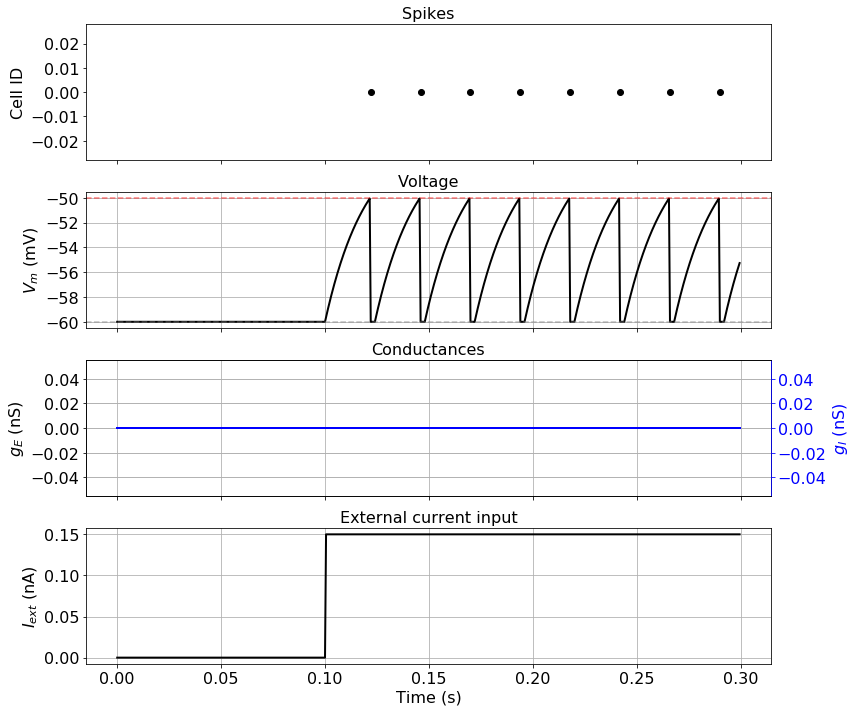

In [3]:
# build 1-cell ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u=None,
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
i_ext[t > 0.1] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell EPSPs:

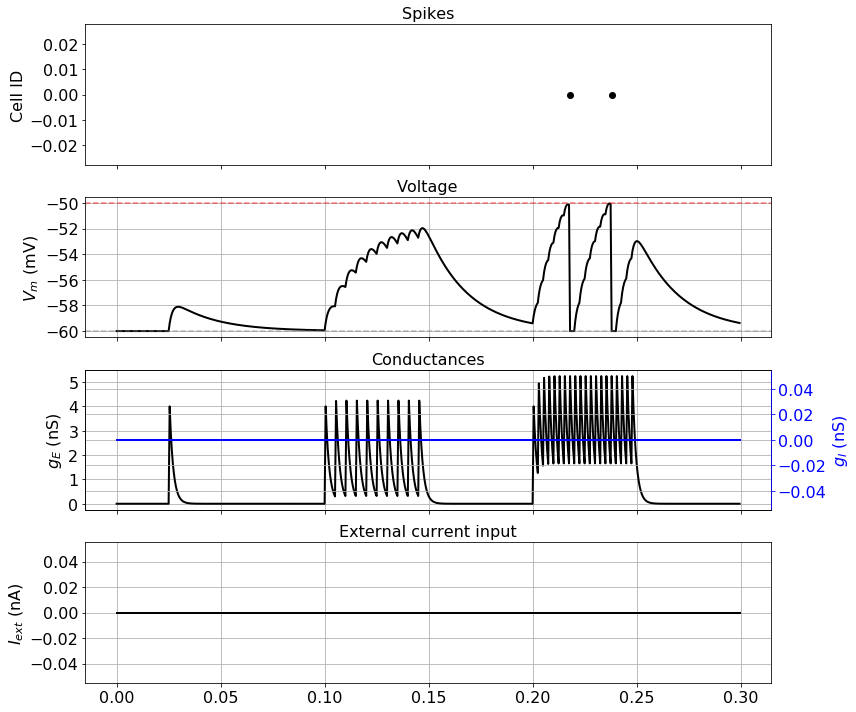

In [4]:
# build 1-cell ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u={'E': 4e-9*np.ones((1, 1))},
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Single-cell IPSPs:

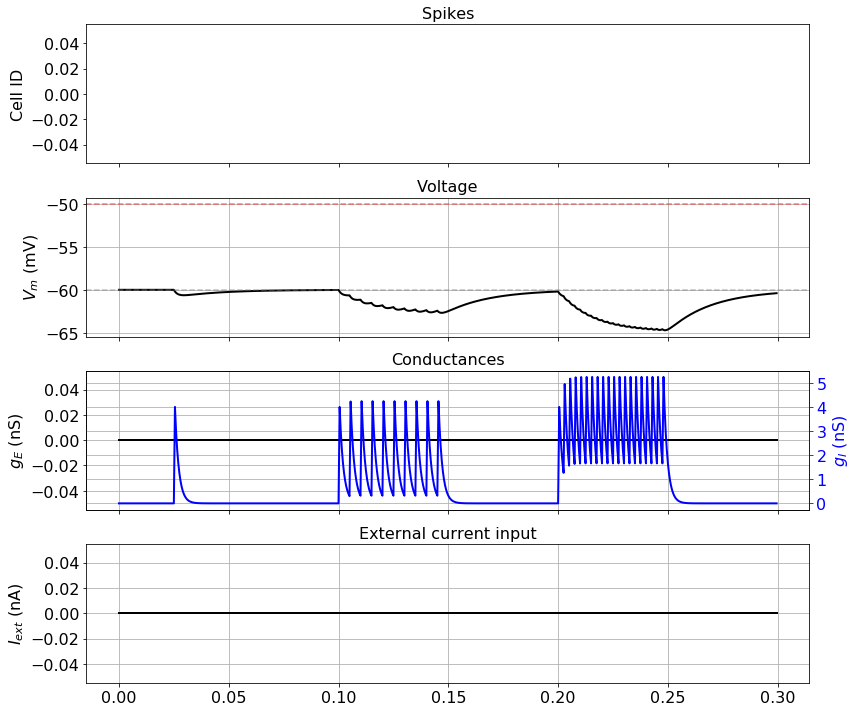

In [5]:
# build 1-cell ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((1, 1)), 'I': np.zeros((1, 1))},
    w_u={'I': 4e-9*np.ones((1, 1))},
    sparse=False)

# run smln for 1-cell ntwk
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros(n_t)
spks_u = np.zeros((n_t, 1))
spks_u[50, 0] = True
spks_u[np.arange(200, 300, 10), 0] = True
spks_u[np.arange(400, 500, 5), 0] = True

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

# plot results
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c='k')
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, 0], lw=2, c='k')
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, 0], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

axs[3].plot(rslt.t, 1e9*rslt.i_ext, lw=2, c='k')
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives EPSPs from cell A.

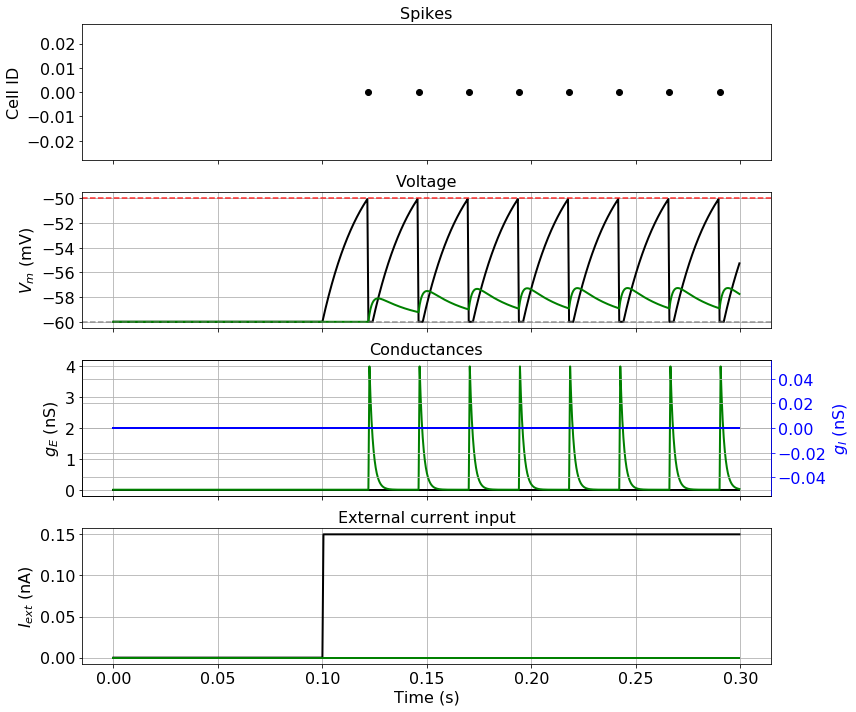

In [6]:
# build 2-cell ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': 4e-9*np.array([[0, 0], [1, 0]]), 'I': np.zeros((2, 2))},
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, i], lw=2, c=c[i])
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, i], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

for i in range(rslt.ntwk.n):
    axs[3].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Two-cell demo where I_ext makes cell A spike and cell B receives IPSPs from cell A.

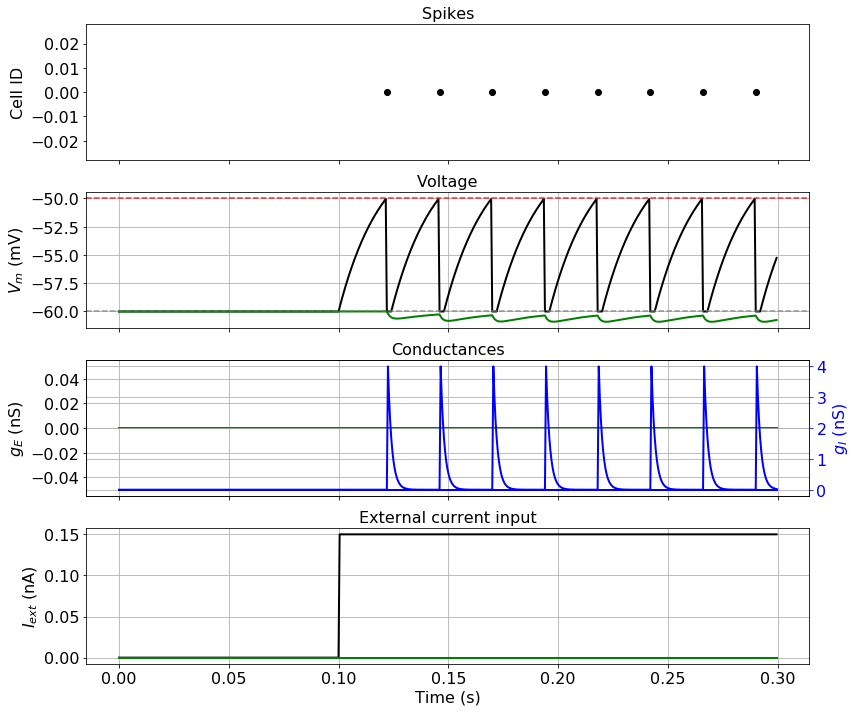

In [7]:
# build 2-cell ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r={'E': np.zeros((2, 2)), 'I': 4e-9*np.array([[0, 0], [1, 0]])},
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = 600
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = np.zeros((n_t, 2))
i_ext[t > 0.1, 0] = .15e-9

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)

# plot results
c = ['k', 'g']
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True, sharex=True)

## spks
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k')
axs[0].set_title('Spikes')
axs[0].set_ylabel('Cell ID')

for i in range(rslt.ntwk.n):
    axs[1].plot(rslt.t, 1e3*rslt.vs[:, i], lw=2, c=c[i])
    axs[1].axhline(1e3*rslt.ntwk.e_l, color='gray', ls='--', alpha=0.5)
    axs[1].axhline(1e3*rslt.ntwk.v_th, color='r', ls='--', alpha=0.5)

axs[1].set_title('Voltage')
axs[1].set_ylabel('$V_m$ (mV)')

ax_2_twin = axs[2].twinx()
for i in range(rslt.ntwk.n):
    axs[2].plot(rslt.t, 1e9*rslt.gs['E'][:, i], lw=2, c=c[i])
    ax_2_twin.plot(rslt.t, 1e9*rslt.gs['I'][:, i], lw=2, c='b')
    
axs[2].set_title('Conductances')
axs[2].set_ylabel('$g_E$ (nS)')
ax_2_twin.set_ylabel('$g_I$ (nS)')

set_color(ax_2_twin, 'b')

for i in range(rslt.ntwk.n):
    axs[3].plot(rslt.t, 1e9*rslt.i_ext[:, i], lw=2, c=c[i])
axs[3].set_title('External current input')
axs[3].set_ylabel('$I_{ext}$ (nA)')
axs[3].set_xlabel('Time (s)')

for ax in list(axs) + [ax_2_twin]:
    set_font_size(ax, 16)
    if ax is not axs[0]:
        ax.grid()

Random EI network demos.

In [8]:
def join_w(targs, srcs, ws):
    """
    Combine multiple weight matrices specific to pairs of populations
    into a single, full set of weight matrices (one per synapse type).
    
    :param targs: dict of boolean masks indicating targ cell classes
    :param srcs: dict of boolean masks indicating source cell classes
    :param ws: dict of inter-population weight matrices, e.g.:
        ws = {
            'E': {
                ('E', 'E'): np.array([[...]]),
                ('I', 'E'): np.array([[...]]),
            },
            'I': {
                ('E', 'I'): np.array([[...]]),
                ('I', 'I'): np.array([[...]]),
            }
        }
        note: keys given as (targ, src)
    
    :return: ws_full, a dict of full ws, one per synapse
    """
    # convert targs/srcs to dicts if given as arrays
    if not isinstance(targs, dict):
        targs_ = copy(targs)
        targs = {
            cell_type: targs_ == cell_type for cell_type in set(targs_)
        }
    if not isinstance(srcs, dict):
        srcs_ = copy(srcs)
        srcs = {
            cell_type: srcs_ == cell_type for cell_type in set(srcs_)
        }
        
    # make sure all targ/src masks have same shape
    targ_shapes = [mask.shape for mask in targs.values()]
    src_shapes = [mask.shape for mask in srcs.values()]
    
    if len(set(targ_shapes)) > 1:
        raise Exception('All targ masks must have same shape.')
        
    if len(set(src_shapes)) > 1:
        raise Exception('All targ masks must have same shape.')
        
    n_targ = targ_shapes[0][0]
    n_src = src_shapes[0][0]
    
    # make sure weight matrix dimensions match sizes
    # of targ/src classes
    for syn, ws_ in ws.items():
        for (targ, src), w_ in ws_.items():
            if not w_.shape == (targs[targ].sum(), srcs[src].sum()):
                raise Exception(
                    'Weight matrix for {}: ({}, {}) does not match '
                    'dimensionality specified by targ/src masks.')
        
    # loop through synapse types
    dtype = list(list(ws.values())[0].values())[0].dtype
    ws_full = {}
    
    for syn, ws_ in ws.items():
        
        w = np.zeros((n_targ, n_src), dtype=dtype)
        
        # loop through population pairs
        for (targ, src), w_ in ws_.items():
            
            # get mask of all cxns from src to targ
            mask = np.outer(targs[targ], srcs[src])
            
            assert mask.sum() == w_.size
            
            w[mask] = w_.flatten()
            
        ws_full[syn] = w
        
    return ws_full

Random EI network response to constant homogeneous input current with I weights turned off.

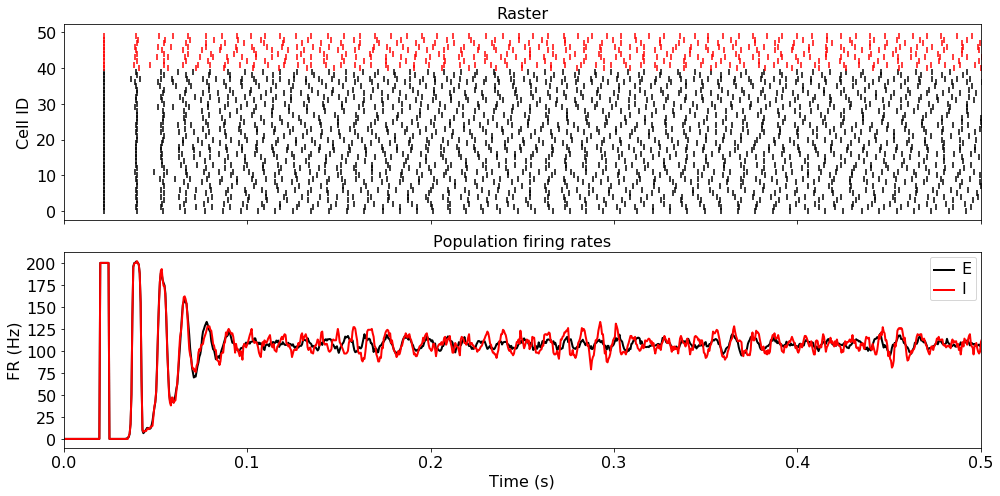

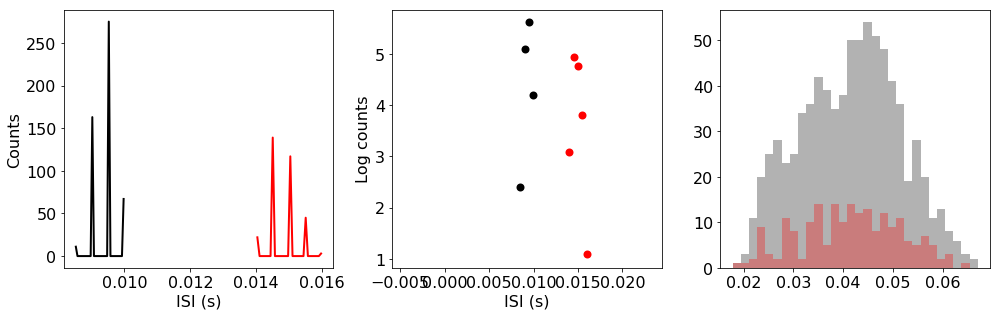

In [9]:
np.random.seed(0)

# set up weight matrix
n_e = 800
n_i = 200
n = n_e + n_i

q = 0.02  # cxn prob
w_ee = 1e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 0  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ei  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if False:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 399.5, 799.5, 899.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.06,  # V
    v_th=-0.05,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.08},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.06}, spk={})
i_ext = .15e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 40  # first 40 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 10)  # first 10 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 40, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .5)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .15, n_e:].T]
## calc ISI coef of variation
cv_e = np.array([stats.variation(isi) for isi in isis_e])
cv_i = np.array([stats.variation(isi) for isi in isis_i])
cv_e = cv_e[~np.isnan(cv_e)]
cv_i = cv_i[~np.isnan(cv_i)]

## make plots
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5), tight_layout=True)

## example ISIs
for ctr in range(1):
    ### excitatory
    cts_e, bins_e = np.histogram(isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    axs[0].plot(bincs_e, cts_e, c='k', lw=2)
    axs[1].scatter(bincs_e, np.log(cts_e), c='k', lw=2)
    
    ### inhibitory
    cts_i, bins_i = np.histogram(isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    axs[0].plot(bincs_i, cts_i, c='r', lw=2)
    axs[1].scatter(bincs_i, np.log(cts_i), c='r', lw=2)
    
axs[0].set_xlabel('ISI (s)')
axs[0].set_ylabel('Counts')

axs[1].set_xlabel('ISI (s)')
axs[1].set_ylabel('Log counts')

## CV distribution
bins = np.histogram(cc([cv_e, cv_i]), bins=30)[1]
### excitatory
axs[2].hist(cv_e, bins, color='k', alpha=0.3)
axs[2].hist(cv_i, bins, color='r', alpha=0.3)

for ax in axs:
    set_font_size(ax, 16)

Demo of asynchronous irregular dynamics in balanced state.

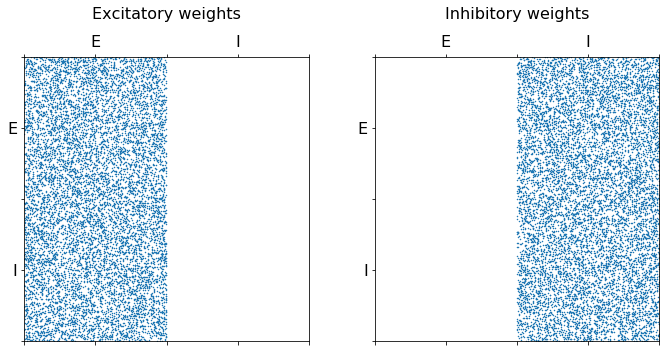

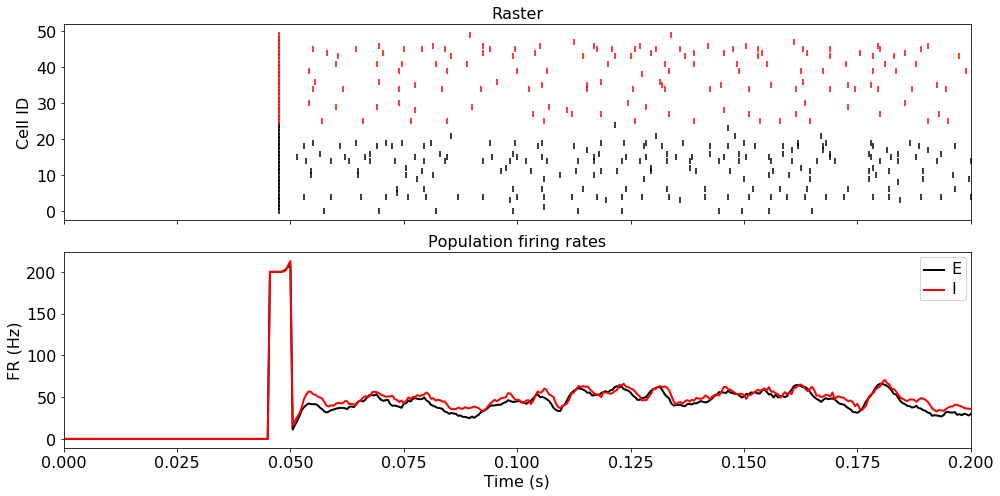

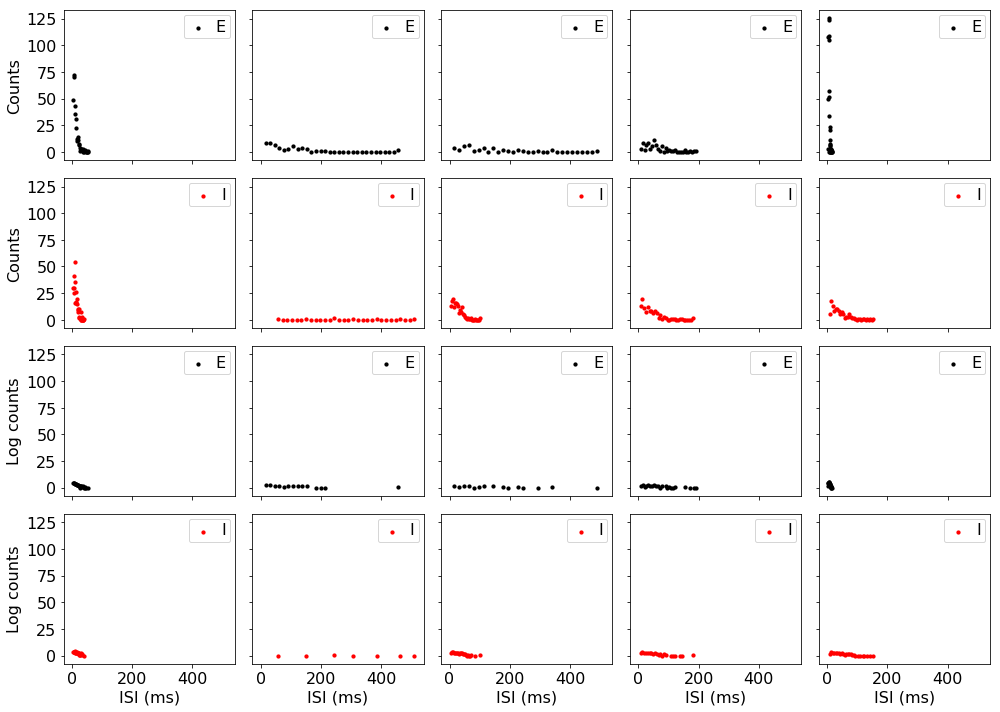

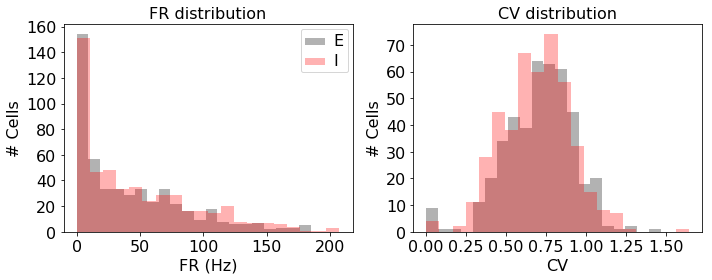

In [21]:
np.random.seed(0)

# set up weight matrix
n_e = 500
n_i = 500
n = n_e + n_i

q = 0.02  # cxn prob
k_e = int(q*n_e)  # num upstream e inputs to each cell
k_i = int(q*n_i)  # num upstream i inputs to each cell
w_ee = 20e-9  # E->E cxn weight
w_ie = w_ee  # E->I cxn weight
g = 1  # scale factor for I weights (w_ei = g*w_ee, w_ii = g*w_ie)
w_ei = g*w_ee  # I->E cxn weight
w_ii = g*w_ei  # I->I cxn weight

## make dict of indiv weight matrices for all cxn types
w_r_indiv = {
    'E': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
    },
    'I': {
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## cell types vector
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

w_r = join_w(ct, ct, w_r_indiv)

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
    axs[0].spy(w_r['E'], markersize=.5)
    axs[0].set_title('Excitatory weights\n')
    axs[1].spy(w_r['I'], markersize=.5)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, 249.5, 499.5, 749.5, 999.5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 16)

# make ntwk
ntwk = LIFNtwk(
    c_m=.2e-9,  # F
    g_l=10e-9,  # S
    e_l=-0.05,  # V
    v_th=-0.04,  # V
    v_r=-0.06,
    t_r=0.002,  # s
    e_s={'E': 0, 'I': -0.1},  # V
    t_s={'E': 0.002, 'I': 0.002},  # s
    w_r=w_r,
    w_u=None,
    sparse=False)

# run smln
dt = 0.0005
n_t = int(5/dt)
t = dt * np.arange(n_t, dtype=float)
clamp = Generic(v={0: -0.05}, spk={})
i_ext = .11e-9 * np.ones((n_t))

rslt = ntwk.run(dt=dt, clamp=clamp, i_ext=i_ext)
spks_t = rslt.spks_t
spks_c = rslt.spks_c

# plot smln results
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, tight_layout=True)

## raster
mask_e = spks_c < 25  # first 25 E cells
axs[0].scatter(spks_t[mask_e], spks_c[mask_e], c='k', marker='|')
mask_i = (n_e <= spks_c) & (spks_c < n_e + 25)  # first 25 I cells
axs[0].scatter(spks_t[mask_i], spks_c[mask_i] - n_e + 25, c='r', marker='|')  # I

axs[0].set_title('Raster')
axs[0].set_ylabel('Cell ID')

## ppln firing rates
wdw_fr_int = int(round(.005/dt))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/dt, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/dt, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, .2)
    set_font_size(ax, 16)
    
# analyze results
## calc ISI distributions
isis_e = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, :n_e].T]
isis_i = [dt*np.diff(spk.nonzero()[0]) for spk in rslt.spks[t >= .2, n_e:].T]

## plot example ISIs
fig, axs = plt.subplots(4, 5, figsize=(14, 10), tight_layout=True, sharex=True, sharey=True)
for ctr, ax_col in enumerate(axs.T):
    # E
    cts_e, bins_e = np.histogram(1000 * isis_e[ctr], bins=30)
    bincs_e = .5*(bins_e[:-1] + bins_e[1:])
    ax_col[0].scatter(bincs_e, cts_e, c='k', lw=2, s=5)
    ax_col[2].scatter(bincs_e, np.log(cts_e), c='k', lw=2, s=5)
    
    ax_col[0].legend(['E'])
    ax_col[2].legend(['E'])
    
    # I
    cts_i, bins_i = np.histogram(1000 * isis_i[ctr], bins=30)
    bincs_i = .5*(bins_i[:-1] + bins_i[1:])
    ax_col[1].scatter(bincs_i, cts_i, c='r', lw=2, s=5)
    ax_col[3].scatter(bincs_i, np.log(cts_i), c='r', lw=2, s=5)
    
    ax_col[1].legend(['I'])
    ax_col[3].legend(['I'])

for ax in axs[:2, 0]:
    ax.set_ylabel('Counts')
for ax in axs[2:, 0]:
    ax.set_ylabel('Log counts')
for ax in axs[-1, :]:
    ax.set_xlabel('ISI (ms)')
for ax in axs.flatten():
    set_font_size(ax, 16)

## calc FR distributions
fr_e = rslt.spks[t >= .2, :n_e].sum(0) / (t[-1] - .2)  # E
fr_i = rslt.spks[t >= .2, n_e:].sum(0) / (t[-1] - .2)  # I

## calc CV (from ISI) distributions
cv_e = np.array([stats.variation(isi) for isi in isis_e])  # E
cv_e = cv_e[~np.isnan(cv_e)]

cv_i = np.array([stats.variation(isi) for isi in isis_i])  # I
cv_i = cv_i[~np.isnan(cv_i)]

## plot FR and ISI-CV distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

axs[0].hist(fr_e, bins=20, color='k', alpha=.3)
axs[0].hist(fr_i, bins=20, color='r', alpha=.3)

axs[1].hist(cv_e, bins=20, color='k', alpha=.3)
axs[1].hist(cv_i, bins=20, color='r', alpha=.3)

axs[0].set_title('FR distribution')
axs[0].set_xlabel('FR (Hz)')
axs[0].legend(['E', 'I'])

axs[1].set_title('CV distribution')
axs[1].set_xlabel('CV')

for ax in axs:
    ax.set_ylabel('# Cells')
    set_font_size(ax, 16)